# Transformación de los datos

In [1]:
#Lectura de la base

# I/O tabular y transformaciones
import pandas as pd

# Operaciones numéricas
import numpy as np

# Manejo robusto de rutas multiplataforma
from pathlib import Path

# constantes de 'quoting' para CSV
import csv

#para descargar 
import re

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("eoinamoore/historical-nba-data-and-player-box-scores")

print("Path to dataset files:", path)

path = Path(path)

c:\Users\jesus\anaconda3\envs\dmemcdm1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 51.8M/51.8M [00:06<00:00, 8.26MB/s]

Extracting files...


Path to dataset files: C:\Users\jesus\.cache\kagglehub\datasets\eoinamoore\historical-nba-data-and-player-box-scores\versions\279


In [3]:
csv_games = path / "Games.csv"
csv_players = path / "Players.csv"
csv_teams = path / "TeamHistories.csv"
csv_players_statistics = path / "PlayerStatistics.csv"
csv_teams_statistics = path / "TeamStatistics.csv"

In [4]:
games_df = pd.read_csv(csv_games)
players_df = pd.read_csv(csv_players)
teams_df = pd.read_csv(csv_teams)
players_statistics_df = pd.read_csv(csv_players_statistics)
teams_statistics_df = pd.read_csv(csv_teams_statistics)

C:\Users\jesus\AppData\Local\Temp\ipykernel_12784\1089091803.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  games_df = pd.read_csv(csv_games)
C:\Users\jesus\AppData\Local\Temp\ipykernel_12784\1089091803.py:4: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  players_statistics_df = pd.read_csv(csv_players_statistics)


In [5]:
print(games_df.columns)
print(players_df.columns)
print(teams_df.columns)
print(players_statistics_df.columns)
print(teams_statistics_df.columns)

Index(['gameId', 'gameDate', 'hometeamCity', 'hometeamName', 'hometeamId',
       'awayteamCity', 'awayteamName', 'awayteamId', 'homeScore', 'awayScore',
       'winner', 'gameType', 'attendance', 'arenaId', 'gameLabel',
       'gameSubLabel', 'seriesGameNumber'],
      dtype='object')
Index(['personId', 'firstName', 'lastName', 'birthdate', 'lastAttended',
       'country', 'height', 'bodyWeight', 'guard', 'forward', 'center',
       'draftYear', 'draftRound', 'draftNumber'],
      dtype='object')
Index(['teamId', 'teamCity', 'teamName', 'teamAbbrev', 'seasonFounded',
       'seasonActiveTill', 'league'],
      dtype='object')
Index(['firstName', 'lastName', 'personId', 'gameId', 'gameDate',
       'playerteamCity', 'playerteamName', 'opponentteamCity',
       'opponentteamName', 'gameType', 'gameLabel', 'gameSubLabel',
       'seriesGameNumber', 'win', 'home', 'numMinutes', 'points', 'assists',
       'blocks', 'steals', 'fieldGoalsAttempted', 'fieldGoalsMade',
       'fieldGoalsPerc

# Transformación en la base players

In [5]:
players_statistics_df["gameType"].value_counts()

gameType
Regular Season        1470402
Playoffs                99840
Preseason               54580
NBA Emirates Cup         1759
Play-in Tournament        829
in-season                 735
Global Games              177
NBA Cup                    28
Name: count, dtype: int64

Limpiar fechas de la base players

In [7]:
df_fechas_prueba = players_statistics_df.copy()

In [8]:
df_fechas_prueba["gameDate"].head()

0    2025-11-19T22:00:00Z
1    2025-11-19T22:00:00Z
2    2025-11-19T22:00:00Z
3    2025-11-19T22:00:00Z
4    2025-11-19T22:00:00Z
Name: gameDate, dtype: object

In [9]:
df_fechas_prueba["gameDate"].tail()

1635846    1946-11-26 19:00:00
1635847    1946-11-26 19:00:00
1635848    1946-11-26 19:00:00
1635849    1946-11-26 19:00:00
1635850    1946-11-26 19:00:00
Name: gameDate, dtype: object

In [6]:

def convertir_fecha(fecha_str):
    try: #intemta esto
        # Primer formato
        if 'T' in fecha_str and 'Z' in fecha_str:
            return pd.to_datetime(fecha_str, format='%Y-%m-%dT%H:%M:%SZ', utc=True)
        else:
            # Segundo formato 
            return pd.to_datetime(fecha_str, format='%Y-%m-%d %H:%M:%S')
    except: # si falla 
        return pd.NaT  # Ya los que de plano no jsja

#Prueba con base copia 
# df_fechas_prueba['gameDate'] = df_fechas_prueba['gameDate'].apply(convertir_fecha)

In [7]:
# función para imputar las fechas faltantes en gameDate

def imputar_fechas_adyacentes(df, columna='gameDate'):
    
    df_temp = df.copy()
    
    for i in range(len(df_temp)):
        if pd.isna(df_temp.loc[i, columna]):
            # Obtener los 
            anterior = df_temp.loc[i-1, columna] if i > 0 else None
            posterior = df_temp.loc[i+1, columna] if i < len(df_temp)-1 else None
            
            # Caso 1: Ambos adyacentes existen y son iguales
            if anterior is not None and posterior is not None and anterior == posterior:
                df_temp.loc[i, columna] = anterior
            
            # Caso 2: Ambos adyacentes existen pero son diferentes
            elif anterior is not None and posterior is not None:
                # Calcular el punto medio en tiempo
                diferencia = posterior - anterior
                punto_medio = anterior + (diferencia / 2)
                df_temp.loc[i, columna] = punto_medio
            
            # Caso 3: Solo existe el anterior
            elif anterior is not None:
                df_temp.loc[i, columna] = anterior
            
            # Caso 4: Solo existe el posterior
            elif posterior is not None:
                df_temp.loc[i, columna] = posterior
    
    return df_temp




Pasar las columna columna gameDate a fechas

In [12]:
players_statistics_df["gameDate"] = players_statistics_df["gameDate"].apply(convertir_fecha)

In [8]:
players_statistics_df = imputar_fechas_adyacentes(players_statistics_df, 'gameDate')


In [13]:
players_statistics_df.isna().sum()

firstName                        0
lastName                         0
personId                         0
gameId                           0
gameDate                        46
playerteamCity                   0
playerteamName                   0
opponentteamCity                 0
opponentteamName                 0
gameType                      7501
gameLabel                  1541969
gameSubLabel               1630510
seriesGameNumber           1500803
win                              0
home                             0
numMinutes                  163020
points                        1219
assists                       1219
blocks                        1219
steals                        1219
fieldGoalsAttempted           1219
fieldGoalsMade                1219
fieldGoalsPercentage          1219
threePointersAttempted        1219
threePointersMade             1219
threePointersPercentage       1219
freeThrowsAttempted           1219
freeThrowsMade                1219
freeThrowsPercentage

Vamos a separar los de regular season y que sea apartir del 2000, para considerar a los 30 equipos y que todos tengan los mismos partidos

In [9]:
df_players = players_statistics_df[players_statistics_df['gameType'] == 'Regular Season']
df_players.shape

(1470402, 35)

In [10]:


#falta el de fechas
from datetime import datetime

#Partidos antes de que comenzar la temporada actual
fecha_fin = datetime(2025, 10, 21)  
fecha_inicio = datetime(1999, 12, 31) 

df_players['gameDate'] = pd.to_datetime(df_players['gameDate'])
df_players = df_players[(df_players['gameDate'] < fecha_fin) & (df_players['gameDate'] > fecha_inicio)]


print(df_players["gameDate"].max())
print(df_players["gameDate"].min())




C:\Users\jesus\AppData\Local\Temp\ipykernel_12784\954401369.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players['gameDate'] = pd.to_datetime(df_players['gameDate'])


2025-04-13 15:30:00
2000-01-02 19:30:00


In [11]:
df_players.shape

(764333, 35)

In [12]:
df_players.columns #el filtrado de fecha y tipo de juego

Index(['firstName', 'lastName', 'personId', 'gameId', 'gameDate',
       'playerteamCity', 'playerteamName', 'opponentteamCity',
       'opponentteamName', 'gameType', 'gameLabel', 'gameSubLabel',
       'seriesGameNumber', 'win', 'home', 'numMinutes', 'points', 'assists',
       'blocks', 'steals', 'fieldGoalsAttempted', 'fieldGoalsMade',
       'fieldGoalsPercentage', 'threePointersAttempted', 'threePointersMade',
       'threePointersPercentage', 'freeThrowsAttempted', 'freeThrowsMade',
       'freeThrowsPercentage', 'reboundsDefensive', 'reboundsOffensive',
       'reboundsTotal', 'foulsPersonal', 'turnovers', 'plusMinusPoints'],
      dtype='object')

In [13]:
players_statistics_df.columns

Index(['firstName', 'lastName', 'personId', 'gameId', 'gameDate',
       'playerteamCity', 'playerteamName', 'opponentteamCity',
       'opponentteamName', 'gameType', 'gameLabel', 'gameSubLabel',
       'seriesGameNumber', 'win', 'home', 'numMinutes', 'points', 'assists',
       'blocks', 'steals', 'fieldGoalsAttempted', 'fieldGoalsMade',
       'fieldGoalsPercentage', 'threePointersAttempted', 'threePointersMade',
       'threePointersPercentage', 'freeThrowsAttempted', 'freeThrowsMade',
       'freeThrowsPercentage', 'reboundsDefensive', 'reboundsOffensive',
       'reboundsTotal', 'foulsPersonal', 'turnovers', 'plusMinusPoints'],
      dtype='object')

# Vamos a unir las bases
Player statistics con player 

In [14]:
#tabla auxiliar que tiene las variables de la tabla player que nos interesan

df_player_cp = players_df[["personId","height","bodyWeight","guard","forward","center"]]

In [15]:
df_aux = pd.merge(
    df_players, df_player_cp,   # Dataframes izquierdo y derecho
    how='left',  # left, right, inner, outer, cross
    on='personId',    # Nombre de la columna llave sobre la que se hace el join
    suffixes=('_origin','_aux'),   # Sufijo a agregar a las columna que compartan nombre en los dos dataframes
    indicator=True, # agrega columna _merge
    validate='many_to_one'  # one_to_one, one_to_many, many_to_many
)

df_aux.columns

Index(['firstName', 'lastName', 'personId', 'gameId', 'gameDate',
       'playerteamCity', 'playerteamName', 'opponentteamCity',
       'opponentteamName', 'gameType', 'gameLabel', 'gameSubLabel',
       'seriesGameNumber', 'win', 'home', 'numMinutes', 'points', 'assists',
       'blocks', 'steals', 'fieldGoalsAttempted', 'fieldGoalsMade',
       'fieldGoalsPercentage', 'threePointersAttempted', 'threePointersMade',
       'threePointersPercentage', 'freeThrowsAttempted', 'freeThrowsMade',
       'freeThrowsPercentage', 'reboundsDefensive', 'reboundsOffensive',
       'reboundsTotal', 'foulsPersonal', 'turnovers', 'plusMinusPoints',
       'height', 'bodyWeight', 'guard', 'forward', 'center', '_merge'],
      dtype='object')

In [16]:
df_aux.shape

(764333, 41)

In [17]:
df_aux = df_aux.dropna(subset=['numMinutes'])

## Análisis de componentes principales 
Vamos a usar la tabla df_aux \
height \
bodyWeight \
numMinutes \
points \
assist \
blocks 


In [104]:
var_pca = ['height','bodyWeight','numMinutes','points','blocks']

In [103]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [105]:
# Las variables a usar
all_numeric_vars = [
    'numMinutes', 'points', 'assists', 'blocks', 'steals', 
    'fieldGoalsAttempted', 'fieldGoalsMade', 'fieldGoalsPercentage',
    'threePointersAttempted', 'threePointersMade', 'threePointersPercentage',
    'freeThrowsAttempted', 'freeThrowsMade', 'freeThrowsPercentage',
    'reboundsDefensive', 'reboundsOffensive', 'reboundsTotal',
    'foulsPersonal', 'turnovers', 'plusMinusPoints'
]

In [106]:
pca_data = df_aux[var_pca].copy()
pca_data = pca_data.dropna()



Normalización de las variables

In [107]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(pca_data)

# Convertir a DataFrame para mejor manejo
data_scaled_df = pd.DataFrame(data_scaled, columns=pca_data.columns)

data_scaled_df.head()

,height,bodyWeight,numMinutes,points,blocks
0,-0.824194,-0.179864,-0.884352,-0.658647,0.625332
1,0.860156,-0.179737,0.721526,2.045070,-0.520375
2,-0.543469,-0.179883,-0.077064,-0.401150,-0.520375
3,-0.824194,-0.179903,-1.273208,-1.173640,-0.520375
4,-0.543469,-0.179903,0.602346,0.757586,0.625332


In [108]:
# Aplicar PCA
pca = PCA()
pca_result = pca.fit_transform(data_scaled_df)

# Crear DataFrame con los componentes
pca_df = pd.DataFrame(
    data=pca_result,
    columns=[f'PC{i+1}' for i in range(pca_result.shape[1])]
)

# Añadir identificadores originales
pca_df['personId'] = players_statistics_df.loc[pca_data.index, 'personId'].values
pca_df['firstName'] = players_statistics_df.loc[pca_data.index, 'firstName'].values
pca_df['lastName'] = players_statistics_df.loc[pca_data.index, 'lastName'].values

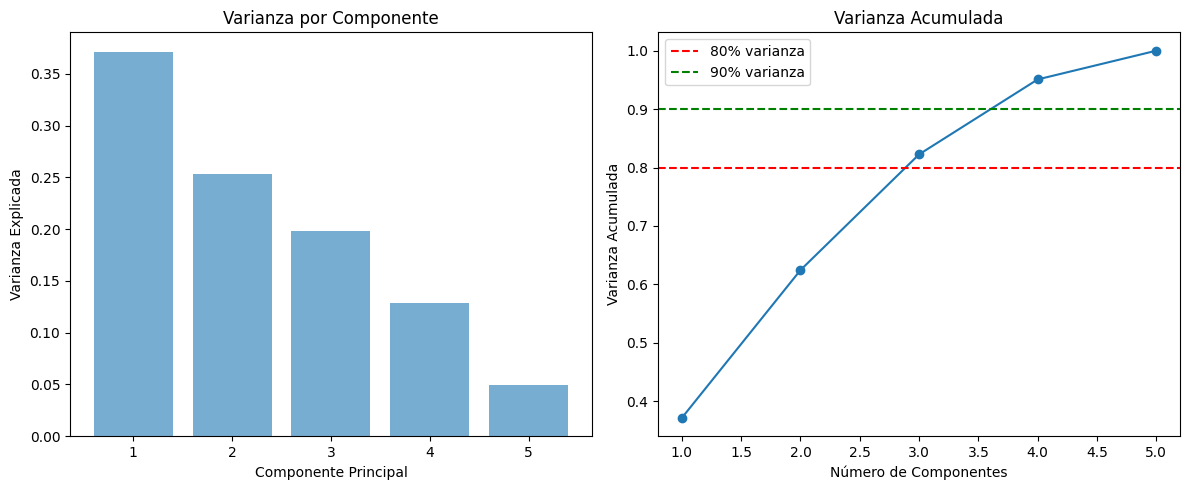

Varianza explicada por los primeros 5 componentes: [0.37155904 0.624458   0.82252531 0.95081879 1.        ]
Componentes necesarios para 80% de varianza: 3
Componentes necesarios para 90% de varianza: 4


In [109]:
# Varianza explicada
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Gráfico de varianza explicada
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6)
plt.xlabel('Componente Principal')
plt.ylabel('Varianza Explicada')
plt.title('Varianza por Componente')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.8, color='r', linestyle='--', label='80% varianza')
plt.axhline(y=0.9, color='g', linestyle='--', label='90% varianza')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada')
plt.title('Varianza Acumulada')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Varianza explicada por los primeros 5 componentes: {cumulative_variance[:5]}")
print(f"Componentes necesarios para 80% de varianza: {np.argmax(cumulative_variance >= 0.8) + 1}")
print(f"Componentes necesarios para 90% de varianza: {np.argmax(cumulative_variance >= 0.9) + 1}")

In [110]:
# Varianza explicada
explained_variance_simple = pca.explained_variance_ratio_
cumulative_simple = np.cumsum(explained_variance_simple)

print("Varianza explicada con variables clave:")
for i, var in enumerate(explained_variance_simple[:5]):
    print(f"PC{i+1}: {var:.3f} ({var:.2%})")

print(f"\nVarianza acumulada primeros 3 PCs: {cumulative_simple[2]:.2%}")

Varianza explicada con variables clave:
PC1: 0.372 (37.16%)
PC2: 0.253 (25.29%)
PC3: 0.198 (19.81%)
PC4: 0.128 (12.83%)
PC5: 0.049 (4.92%)

Varianza acumulada primeros 3 PCs: 82.25%


In [111]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=pca_data.columns
)

Text(0.5, 1.0, 'Cargas de Variables en los Primeros 5 Component')

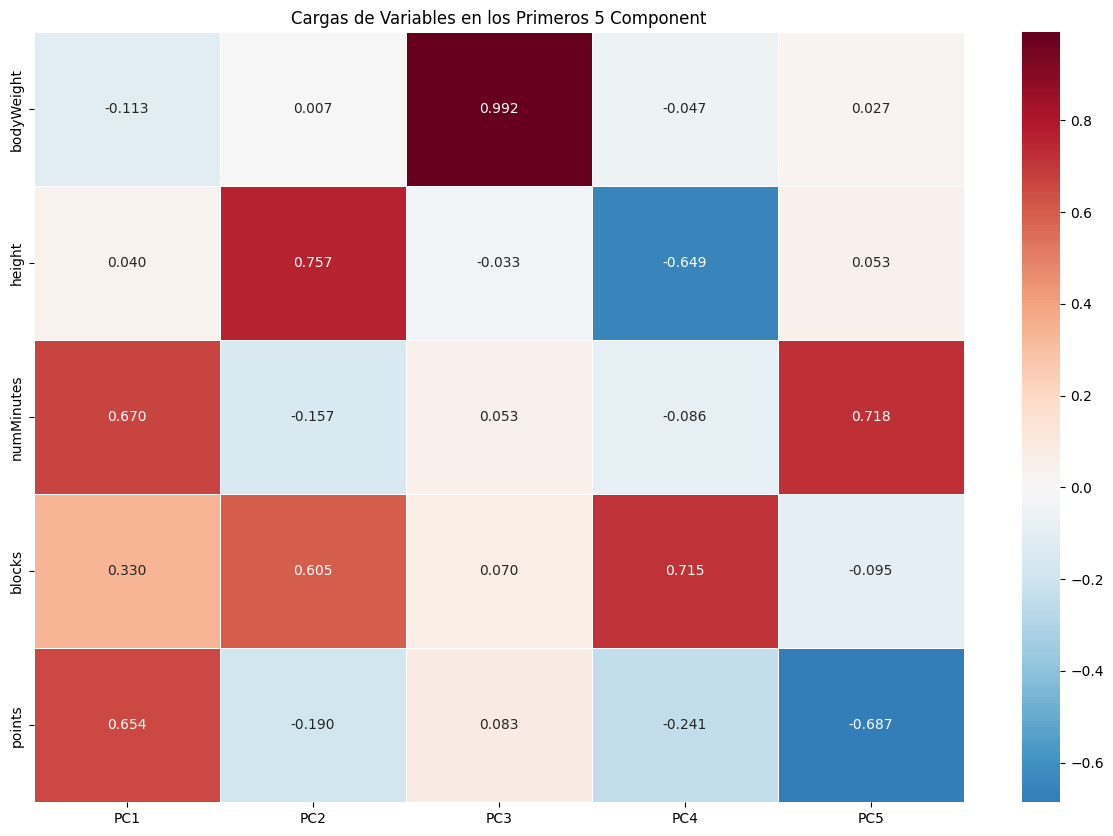

In [112]:
# Heatmap de las cargas de los primeros 5 componentes
plt.figure(figsize=(15, 10))
top_vars = loadings.abs().max(axis=1).sort_values(ascending=False).head(15).index

sns.heatmap(
    loadings.loc[top_vars, ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']],
    annot=True, cmap='RdBu_r', center=0,
    fmt='.3f', linewidths=0.5
)
plt.title('Cargas de Variables en los Primeros 5 Component')

Variables más influyentes en este plano:
  bodyWeight: longitud = 0.113
  points: longitud = 0.681
  numMinutes: longitud = 0.688
  blocks: longitud = 0.689
  height: longitud = 0.758


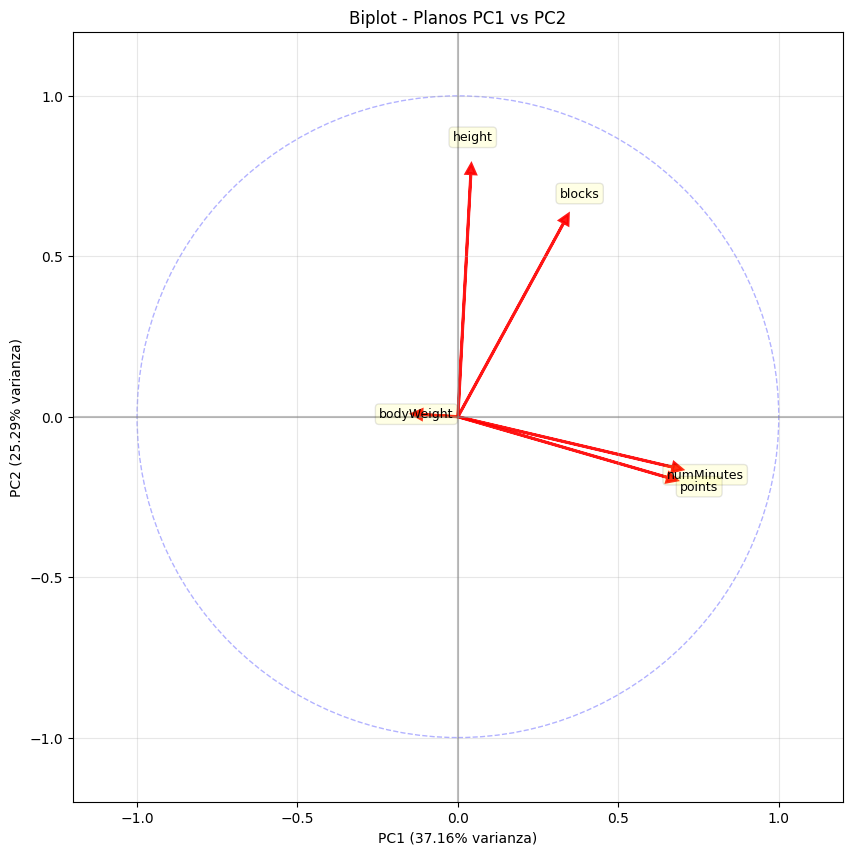

In [ ]:
def enhanced_biplot(pca, features, component_x=0, component_y=1, highlight_top=5):
    """
    Biplot mejorado con colores y destacando variables importantes
    """
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Círculo unitario
    circle = plt.Circle((0, 0), 1, color='blue', fill=False, linestyle='--', alpha=0.3)
    ax.add_artist(circle)
    
    # Límites
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.axhline(0, color='gray', alpha=0.5)
    ax.axvline(0, color='gray', alpha=0.5)
    
    # Loadings
    loadings = pca.components_.T
    
    # Calcular importancia de variables (longitud del vector)
    importance = np.sqrt(loadings[:, component_x]**2 + loadings[:, component_y]**2)
    top_indices = np.argsort(importance)[-highlight_top:]
    
    # Dibujar flechas
    for i in range(len(features)):
        color = 'red' if i in top_indices else 'blue'
        alpha = 0.9 if i in top_indices else 0.5
        linewidth = 2 if i in top_indices else 1
        
        ax.arrow(0, 0, loadings[i, component_x], loadings[i, component_y],
                head_width=0.03, head_length=0.03, 
                fc=color, ec=color, alpha=alpha, linewidth=linewidth)
        
        
        bbox_props = dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.1)
        ax.text(loadings[i, component_x] * 1.15, loadings[i, component_y] * 1.15,
               features[i], ha='center', va='center', fontsize=9, bbox=bbox_props)
    
    # Variables más importantes
    print("Variables más influyentes en este plano:")
    for i in top_indices:
        length = importance[i]
        print(f"  {features[i]}: longitud = {length:.3f}")
    
    variance = pca.explained_variance_ratio_
    ax.set_xlabel(f'PC{component_x+1} ({variance[component_x]:.2%} varianza)')
    ax.set_ylabel(f'PC{component_y+1} ({variance[component_y]:.2%} varianza)')
    ax.set_title(f'Biplot - Planos PC{component_x+1} vs PC{component_y+1}')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    return fig, ax


fig, ax = enhanced_biplot(pca, var_pca, component_x=0, component_y=1)
plt.show()

In [68]:
all_numeric_vars



['numMinutes',
 'points',
 'assists',
 'blocks',
 'steals',
 'fieldGoalsAttempted',
 'fieldGoalsMade',
 'fieldGoalsPercentage',
 'threePointersAttempted',
 'threePointersMade',
 'threePointersPercentage',
 'freeThrowsAttempted',
 'freeThrowsMade',
 'freeThrowsPercentage',
 'reboundsDefensive',
 'reboundsOffensive',
 'reboundsTotal',
 'foulsPersonal',
 'turnovers',
 'plusMinusPoints']

In [71]:
analizar = ["points","numMinutes", "threePointersPercentage", "reboundsDefensive", "reboundsOffensive"]

# Transformación para equipos

In [18]:
teams_df.columns

Index(['teamId', 'teamCity', 'teamName', 'teamAbbrev', 'seasonFounded',
       'seasonActiveTill', 'league'],
      dtype='object')

In [19]:
teams_statistics_df.columns

Index(['gameId', 'gameDate', 'teamCity', 'teamName', 'teamId',
       'opponentTeamCity', 'opponentTeamName', 'opponentTeamId', 'home', 'win',
       'teamScore', 'opponentScore', 'assists', 'blocks', 'steals',
       'fieldGoalsAttempted', 'fieldGoalsMade', 'fieldGoalsPercentage',
       'threePointersAttempted', 'threePointersMade',
       'threePointersPercentage', 'freeThrowsAttempted', 'freeThrowsMade',
       'freeThrowsPercentage', 'reboundsDefensive', 'reboundsOffensive',
       'reboundsTotal', 'foulsPersonal', 'turnovers', 'plusMinusPoints',
       'numMinutes', 'q1Points', 'q2Points', 'q3Points', 'q4Points',
       'benchPoints', 'biggestLead', 'biggestScoringRun', 'leadChanges',
       'pointsFastBreak', 'pointsFromTurnovers', 'pointsInThePaint',
       'pointsSecondChance', 'timesTied', 'timeoutsRemaining', 'seasonWins',
       'seasonLosses', 'coachId'],
      dtype='object')

In [20]:
teams_statistics_df["gameDate"] = teams_statistics_df["gameDate"].apply(convertir_fecha)

In [ ]:
teams_statistics_df = teams_statistics_df[teams_statistics_df[""]]

In [ ]:
teams_statistics_df =  teams_statistics_df.dropna(subset="gameDate")

In [87]:
df_union_team = pd.merge(
    df_players, teams_statistics_df,
    how = "left",
    on = "gameId",
    suffixes=("_player", "_team"),
    indicator=True,
    validate = "many_to_many"
)

df_union_team.head()

,firstName,lastName,personId,gameId,gameDate_player,playerteamCity,playerteamName,opponentteamCity,opponentteamName,gameType,...,pointsFastBreak,pointsFromTurnovers,pointsInThePaint,pointsSecondChance,timesTied,timeoutsRemaining,seasonWins,seasonLosses,coachId,_merge
0,Chris,Paul,101108,22401197,2025-04-13 15:30:00,San Antonio,Spurs,Toronto,Raptors,Regular Season,...,18.0,15.0,58.0,10.0,9.0,0.0,34.0,48.0,NaN,both
1,Chris,Paul,101108,22401197,2025-04-13 15:30:00,San Antonio,Spurs,Toronto,Raptors,Regular Season,...,22.0,18.0,54.0,12.0,9.0,0.0,30.0,52.0,NaN,both
2,Tyus,Jones,1626145,22401200,2025-04-13 15:30:00,Phoenix,Suns,Sacramento,Kings,Regular Season,...,7.0,13.0,40.0,7.0,1.0,1.0,36.0,46.0,NaN,both
3,Tyus,Jones,1626145,22401200,2025-04-13 15:30:00,Phoenix,Suns,Sacramento,Kings,Regular Season,...,11.0,20.0,44.0,14.0,1.0,1.0,40.0,42.0,NaN,both
4,Trey,Lyles,1626168,22401200,2025-04-13 15:30:00,Sacramento,Kings,Phoenix,Suns,Regular Season,...,7.0,13.0,40.0,7.0,1.0,1.0,36.0,46.0,NaN,both


In [55]:
df_union_team.columns

Index(['firstName', 'lastName', 'personId', 'gameId', 'gameDate_player',
       'playerteamCity', 'playerteamName', 'opponentteamCity',
       'opponentteamName', 'gameType', 'gameLabel', 'gameSubLabel',
       'seriesGameNumber', 'win_player', 'home_player', 'numMinutes_player',
       'points', 'assists_player', 'blocks_player', 'steals_player',
       'fieldGoalsAttempted_player', 'fieldGoalsMade_player',
       'fieldGoalsPercentage_player', 'threePointersAttempted_player',
       'threePointersMade_player', 'threePointersPercentage_player',
       'freeThrowsAttempted_player', 'freeThrowsMade_player',
       'freeThrowsPercentage_player', 'reboundsDefensive_player',
       'reboundsOffensive_player', 'reboundsTotal_player',
       'foulsPersonal_player', 'turnovers_player', 'plusMinusPoints_player',
       'gameDate_team', 'teamCity', 'teamName', 'teamId', 'opponentTeamCity',
       'opponentTeamName', 'opponentTeamId', 'home_team', 'win_team',
       'teamScore', 'opponentScore',

In [88]:
df_trans = df_union_team[["teamId","win_team","teamScore","opponentScore","fieldGoalsAttempted_team","freeThrowsAttempted_team",
                          "freeThrowsAttempted_team","turnovers_team"]]
df_trans.isna().sum()

teamId                      0
win_team                    0
teamScore                   0
opponentScore               0
fieldGoalsAttempted_team    0
freeThrowsAttempted_team    0
freeThrowsAttempted_team    0
turnovers_team              0
dtype: int64

In [63]:
vars_heatmap = [
    'teamScore', 'fieldGoalsPercentage_team', 'threePointersPercentage_team',
    'freeThrowsPercentage_team', 'reboundsOffensive_team', 'reboundsDefensive_team',
    'assists_team', 'steals_team', 'blocks_team', 'turnovers_team',
    'biggestLead', 'biggestScoringRun', 'benchPoints'
]

Lista de equipos actuales

In [89]:
teams_current = [
    "Spurs",
    "Raptors",
    "Suns",
    "Kings",
    "Warriors",
    "Clippers",
    "Nuggets",
    "Rockets",
    "Pelicans",
    "Thunder",
    "Mavericks",
    "Grizzlies",
    "Timberwolves",
    "Jazz",
    "Lakers",
    "Trail Blazers",
    "Nets",
    "Knicks",
    "Heat",
    "Wizards",
    "Bulls",
    "76ers",
    "Cavaliers",
    "Pacers",
    "Bucks",
    "Pistons",
    "Celtics",
    "Hornets",
    "Hawks",
    "Magic"
]


In [90]:
df_union_team = df_union_team[df_union_team["teamName"].isin(teams_current)]

In [91]:
df_union_team["teamName"].unique()

array(['Spurs', 'Raptors', 'Suns', 'Kings', 'Warriors', 'Clippers',
       'Nuggets', 'Rockets', 'Pelicans', 'Thunder', 'Mavericks',
       'Grizzlies', 'Timberwolves', 'Jazz', 'Lakers', 'Trail Blazers',
       'Nets', 'Knicks', 'Heat', 'Wizards', 'Bulls', '76ers', 'Cavaliers',
       'Pacers', 'Bucks', 'Pistons', 'Celtics', 'Hornets', 'Hawks',
       'Magic'], dtype=object)

In [98]:
df_team = df_union_team.groupby('teamName')[vars_heatmap].mean()
df_team

,teamScore,fieldGoalsPercentage_team,threePointersPercentage_team,freeThrowsPercentage_team,reboundsOffensive_team,reboundsDefensive_team,assists_team,steals_team,blocks_team,turnovers_team,biggestLead,biggestScoringRun,benchPoints
teamName,,,,,,,,,,,,,
76ers,101.272379,0.453896,0.342850,0.756958,11.089769,31.551329,22.469813,8.392423,4.949033,14.649195,9.766730,9.452875,31.138549
Bucks,104.040048,0.461208,0.361958,0.758867,10.818833,32.251407,23.163336,7.542008,4.747953,14.138830,14.041667,10.575269,36.194444
Bulls,100.381837,0.449598,0.356234,0.764886,11.207201,32.374624,22.900379,7.389482,4.901853,14.705992,11.908470,9.785519,35.746812
Cavaliers,101.734665,0.455264,0.352840,0.750542,11.318102,31.716075,22.420277,7.254549,4.538118,14.385626,18.372290,11.009425,39.740811
Celtics,103.303742,0.458489,0.357857,0.776145,10.284485,32.143423,23.082628,8.020330,4.713876,14.362430,18.277598,10.363972,30.107621
Clippers,103.066711,0.462434,0.356027,0.756662,10.715561,32.053783,22.511346,7.425868,5.138480,14.476292,15.378937,10.344617,31.571227
Grizzlies,101.206232,0.454817,0.345639,0.756096,11.368024,31.147615,22.347217,8.199524,5.235580,14.560060,15.691529,10.559392,43.979282
Hawks,102.383433,0.456067,0.353114,0.768038,10.937093,31.486387,22.953906,7.752461,4.806032,14.807050,11.661614,10.305623,43.625428
Heat,100.204408,0.461686,0.356492,0.752923,9.871638,31.845694,21.990543,7.491873,4.777862,14.049014,13.778121,10.460079,35.760918


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_z = pd.DataFrame(
    scaler.fit_transform(df_team),
    columns=df_team.columns,
    index=df_team.index
)

,teamScore,fieldGoalsPercentage_team,threePointersPercentage_team,freeThrowsPercentage_team,reboundsOffensive_team,reboundsDefensive_team,assists_team,steals_team,blocks_team,turnovers_team,biggestLead,biggestScoringRun,benchPoints
teamName,,,,,,,,,,,,,
76ers,-0.795180,-0.641703,-1.988847,-0.586092,0.282257,-0.632008,-0.364738,2.322400,0.134828,0.713250,-1.055042,-1.410394,-0.784651
Bucks,0.372758,0.594471,1.239564,-0.408368,-0.349125,0.422348,0.410220,-0.242675,-0.514585,-0.417159,0.292622,0.861591,0.125495
Bulls,-1.170983,-1.368394,0.272567,0.152199,0.555915,0.607920,0.116387,-0.702733,-0.017544,0.839050,-0.379863,-0.737045,0.044914
Cavaliers,-0.600098,-0.410525,-0.300881,-1.183671,0.814355,-0.383892,-0.420090,-1.109726,-1.192274,0.129470,1.657841,1.740424,0.763901
Celtics,0.062042,0.134801,0.546726,1.200792,-1.594350,0.259718,0.320035,1.200070,-0.624641,0.078094,1.627989,0.433878,-0.970236
Clippers,-0.037984,0.801738,0.237596,-0.613721,-0.589786,0.124715,-0.318327,-0.592983,0.746672,0.330286,0.714193,0.394698,-0.706762
Grizzlies,-0.823094,-0.486017,-1.517622,-0.666450,0.930691,-1.240024,-0.501729,1.740566,1.060268,0.515824,0.812737,0.829454,1.526897
Hawks,-0.326322,-0.274731,-0.254713,0.445780,-0.073536,-0.729814,0.176199,0.392108,-0.327010,1.062883,-0.457684,0.315767,1.463197
Heat,-1.245857,0.675429,0.316090,-0.961920,-2.556434,-0.188679,-0.900285,-0.393894,-0.417990,-0.616091,0.209540,0.628421,0.047453


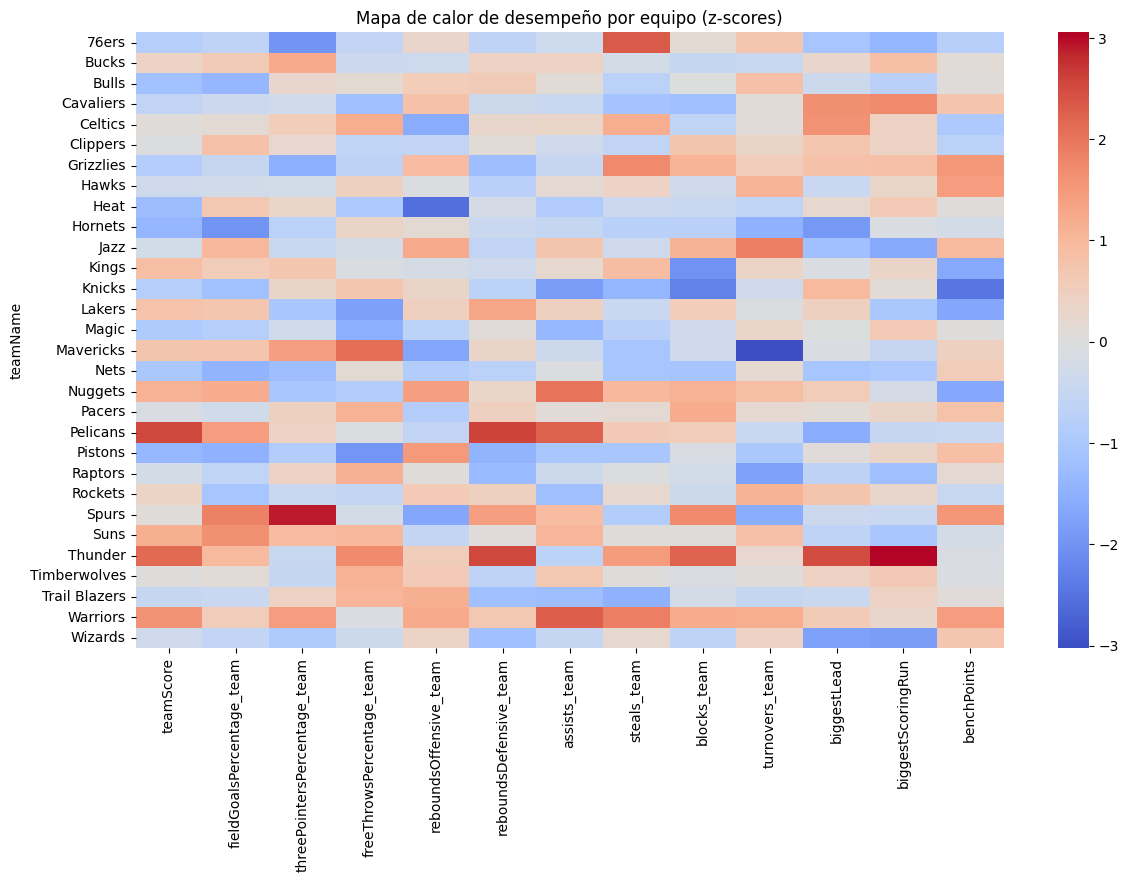

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,8))
sns.heatmap(df_z, cmap="coolwarm", center=0)
plt.title("Mapa de calor de desempeño por equipo (z-scores)")
plt.show()